In [1]:
import transformer_lens as tl
import torch as t
import torch.nn.functional as F
import dataclasses as dc
from typing import Optional
from enum import Enum
from pprint import pprint
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import random

flatten = itertools.chain.from_iterable


In [2]:
device = t.device("cuda" if t.cuda.is_available() else t.device("mps"))

model = tl.HookedTransformer.from_pretrained(
    "redwood_attn_2l",  # load Redwood's model
    center_writing_weights=False,  # these are needed as this model is a Shortformer; this is a technical detail
    center_unembed=False,
    fold_ln=False,
    device=device
).to(device)

t.random.manual_seed(42)

# NOTE. The following lines are present in the code of the official repo,
# but I don't know what it really does.

model.set_use_attn_result(True)     
model.set_use_split_qkv_input(True)

Loaded pretrained model redwood_attn_2l into HookedTransformer
Moving model to device:  cuda


In [3]:
for name, parameters in model.named_parameters():
    print(f"{name}: {parameters.shape}")


embed.W_E: torch.Size([50259, 256])
pos_embed.W_pos: torch.Size([2048, 256])
blocks.0.ln1.w: torch.Size([256])
blocks.0.ln1.b: torch.Size([256])
blocks.0.attn.W_Q: torch.Size([8, 256, 32])
blocks.0.attn.W_O: torch.Size([8, 32, 256])
blocks.0.attn.b_Q: torch.Size([8, 32])
blocks.0.attn.b_O: torch.Size([256])
blocks.0.attn.W_K: torch.Size([8, 256, 32])
blocks.0.attn.W_V: torch.Size([8, 256, 32])
blocks.0.attn.b_K: torch.Size([8, 32])
blocks.0.attn.b_V: torch.Size([8, 32])
blocks.1.ln1.w: torch.Size([256])
blocks.1.ln1.b: torch.Size([256])
blocks.1.attn.W_Q: torch.Size([8, 256, 32])
blocks.1.attn.W_O: torch.Size([8, 32, 256])
blocks.1.attn.b_Q: torch.Size([8, 32])
blocks.1.attn.b_O: torch.Size([256])
blocks.1.attn.W_K: torch.Size([8, 256, 32])
blocks.1.attn.W_V: torch.Size([8, 256, 32])
blocks.1.attn.b_K: torch.Size([8, 32])
blocks.1.attn.b_V: torch.Size([8, 32])
ln_final.w: torch.Size([256])
ln_final.b: torch.Size([256])
unembed.W_U: torch.Size([256, 50259])
unembed.b_U: torch.Size([5025

In [4]:
# NOTE. I got this code from ARENA.

def generate_repeated_tokens(
    model: tl.HookedTransformer,
    seq_len: int,
    num_seq: int = 1
) -> t.Tensor:
    prefix = (t.ones(num_seq, 1) * model.tokenizer.bos_token_id).long()
    rep_tokens_half = t.randint(0, model.cfg.d_vocab, (num_seq, seq_len), dtype=t.int64)
    rep_tokens = t.cat([prefix, rep_tokens_half, rep_tokens_half], dim=-1).to(device)
    return rep_tokens

seq_len = 150
num_seq = 10

dataset = generate_repeated_tokens(model=model, seq_len=seq_len, num_seq=num_seq)[:, :-1]
dataset.shape


torch.Size([10, 300])

In [5]:
logits, cache = model.run_with_cache(dataset)
for name, values in cache.items():
    print(f"{name}: {values.shape}")


hook_embed: torch.Size([10, 300, 256])
hook_pos_embed: torch.Size([10, 300, 256])
blocks.0.hook_resid_pre: torch.Size([10, 300, 256])
blocks.0.hook_q_input: torch.Size([10, 300, 8, 256])
blocks.0.hook_k_input: torch.Size([10, 300, 8, 256])
blocks.0.hook_v_input: torch.Size([10, 300, 8, 256])
blocks.0.ln1.hook_scale: torch.Size([10, 300, 8, 1])
blocks.0.ln1.hook_normalized: torch.Size([10, 300, 8, 256])
blocks.0.attn.hook_q: torch.Size([10, 300, 8, 32])
blocks.0.attn.hook_k: torch.Size([10, 300, 8, 32])
blocks.0.attn.hook_v: torch.Size([10, 300, 8, 32])
blocks.0.attn.hook_attn_scores: torch.Size([10, 8, 300, 300])
blocks.0.attn.hook_pattern: torch.Size([10, 8, 300, 300])
blocks.0.attn.hook_z: torch.Size([10, 300, 8, 32])
blocks.0.attn.hook_result: torch.Size([10, 300, 8, 256])
blocks.0.hook_attn_out: torch.Size([10, 300, 256])
blocks.0.hook_resid_post: torch.Size([10, 300, 256])
blocks.1.hook_resid_pre: torch.Size([10, 300, 256])
blocks.1.hook_q_input: torch.Size([10, 300, 8, 256])
bloc

In [6]:
@dc.dataclass(frozen=True)
class TransformerNode:
    hook_name: str
    head_idx: Optional[int] = None

    @property
    def index(self):
        colon = slice(None)
        head_idx = self.head_idx

        if head_idx is not None: return tuple([colon, colon, head_idx, colon])
        else: return tuple([colon, colon, colon])
    
    def __repr__(self):
        head_idx = self.head_idx
        return f"N({self.hook_name}{f'({head_idx})' if head_idx is not None else ''})"

class TransformerEdgeType(Enum):
    ADDITION = 0
    DIRECT_COMPUTATION = 1
    PLACEHOLDER = 2

    def __repr__(self):
        return self.name

def setup_nx_graph_from_model(model: tl.HookedTransformer):
    graph = nx.DiGraph()
    
    n_layers = model.cfg.n_layers
    residual_stream_nodes: list[TransformerNode] = []

    logits_node = TransformerNode(f"blocks.{n_layers-1}.hook_resid_post")

    graph.add_node(logits_node, incoming_edge_type=TransformerEdgeType.ADDITION, subset="logits")
    residual_stream_nodes.append(logits_node)

    for layer_idx in range(model.cfg.n_layers - 1, -1, -1):
        new_residual_stream_nodes: list[TransformerNode] = []

        for head_idx in range(model.cfg.n_heads - 1, -1, -1):
            cur_head_node = TransformerNode(f"blocks.{layer_idx}.attn.hook_result", head_idx)
            graph.add_node(cur_head_node, incoming_edge_type=TransformerEdgeType.PLACEHOLDER, subset=f"layer {layer_idx} result")
    
            for residual_stream_node in residual_stream_nodes:
                graph.add_edge(
                    cur_head_node, residual_stream_node,
                    edge_type=TransformerEdgeType.ADDITION,
                )

            for letter in "qkv":
                letter_hook_node = TransformerNode(f"blocks.{layer_idx}.attn.hook_{letter}", head_idx)
                graph.add_node(letter_hook_node, incoming_edge_type=TransformerEdgeType.DIRECT_COMPUTATION, subset=f"layer {layer_idx} letter")

                letter_input_hook_node = TransformerNode(f"blocks.{layer_idx}.hook_{letter}_input", head_idx)
                graph.add_node(letter_input_hook_node, incoming_edge_type=TransformerEdgeType.ADDITION, subset=f"layer {layer_idx} input")

                graph.add_edge(
                    letter_hook_node, cur_head_node,
                    edge_type=TransformerEdgeType.PLACEHOLDER,
                )

                graph.add_edge(
                    letter_input_hook_node, letter_hook_node,
                    edge_type=TransformerEdgeType.DIRECT_COMPUTATION,
                )

                new_residual_stream_nodes.append(letter_input_hook_node)

        residual_stream_nodes.extend(new_residual_stream_nodes)

    token_embed_node = TransformerNode(hook_name="hook_embed")

    # NOTE. For now, we will always include the positional embedding node. 

    embed_nodes = [token_embed_node]#, pos_embed_node]

    for embed_node in embed_nodes:
        graph.add_node(embed_node, incoming_edge_type=TransformerEdgeType.PLACEHOLDER, subset="embed")

        for residual_stream_node in residual_stream_nodes:
            graph.add_edge(
                embed_node, residual_stream_node,
                edge_type=TransformerEdgeType.ADDITION
            )

    for u, v, data in graph.edges.data():
        data["present"] = True
        v = graph.nodes[v]
        assert data["edge_type"] == v["incoming_edge_type"]

    # Create node labels based on the node attributes
    labels = {}
    for node in graph.nodes:
        if 'hook_q_input' in node.hook_name:
            labels[node] = f"Qi.{node.head_idx}"
        elif 'hook_k_input' in node.hook_name:
            labels[node] = f"Ki.{node.head_idx}"
        elif 'hook_v_input' in node.hook_name:
            labels[node] = f"Vi.{node.head_idx}"
        elif 'attn.hook_q' in node.hook_name:
            labels[node] = f"Q.{node.head_idx}"
        elif 'attn.hook_k' in node.hook_name:
            labels[node] = f"K.{node.head_idx}"
        elif 'attn.hook_v' in node.hook_name:
            labels[node] = f"V.{node.head_idx}"
        elif 'hook_resid_post' in node.hook_name:
            labels[node] = f"O"
        elif 'attn.hook_result' in node.hook_name:
            labels[node] = f"R.{node.head_idx}"
        elif 'hook_embed' in node.hook_name:
            labels[node] = "E"
        else:
            labels[node] = node.hook_name

    return graph, labels


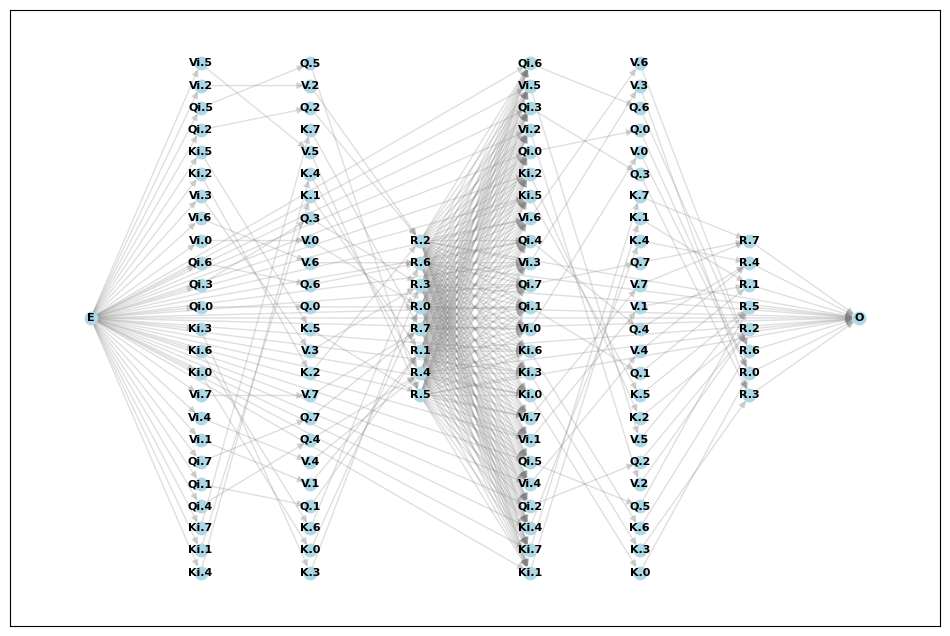

In [7]:
graph, labels = setup_nx_graph_from_model(model)

plt.figure(figsize=(12, 8))
pos = nx.multipartite_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=80, node_color='lightblue')
nx.draw_networkx_edges(graph, pos, node_size=80, alpha=0.25, edge_color='grey')
nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_weight=700, font_color='black')
plt.show()

In [8]:
# Setup corrupted and online cache

model.reset_hooks()

model.add_hook(
    name = lambda hook_name: any([substring in hook_name for substring in ["hook_result", "hook_pos_embed", "hook_embed"]]),
    hook = lambda z, hook: t.zeros_like(z))

_, corrupted_cache = model.run_with_cache(dataset)
online_cache = dict()

model.reset_hooks()


In [9]:
def receiver_hook(hook_tensor, hook):
    hook_nodes = [node for node in graph.nodes if node.hook_name == hook.name]
    incoming_edge_types = [graph.nodes[node]['incoming_edge_type'] for node in hook_nodes]
    
    if TransformerEdgeType.DIRECT_COMPUTATION in incoming_edge_types:
        assert incoming_edge_types == [TransformerEdgeType.DIRECT_COMPUTATION for _ in incoming_edge_types], f"All incoming edges should be the same type not {incoming_edge_types}"
    
        old_z = hook_tensor.clone()
        hook_tensor[:] = corrupted_cache[hook.name]
    
        for receiver in hook_nodes:
            senders = [sender for sender, _, data in graph.in_edges(receiver, data=True) if data["present"]]

            assert len(senders) <= 1, "This is a direct computation, so there should only be one sender node"
            if len(senders) == 0: continue

            hook_tensor[receiver.index] = old_z[receiver.index]

    
    if TransformerEdgeType.ADDITION in incoming_edge_types:
        assert incoming_edge_types == [TransformerEdgeType.ADDITION for _ in incoming_edge_types], f"All incoming edges should be the same type, not {incoming_edge_types}"
        hook_tensor[:] = corrupted_cache[hook.name]
        
        for receiver in hook_nodes:
            for sender, _, data in graph.in_edges(receiver, data=True):
                if not data["present"]:
                    continue

                assert data["edge_type"] == TransformerEdgeType.ADDITION
            
                hook_tensor[receiver.index] += online_cache[sender.hook_name][sender.index]
                hook_tensor[receiver.index] -= corrupted_cache[sender.hook_name][sender.index]
    
    return hook_tensor

def sender_hook(hook_tensor, hook):
    online_cache[hook.name] = hook_tensor
    return hook_tensor
    

In [10]:
model.reset_hooks()

receiver_hook_names = set([
    node.hook_name
    for node, data in graph.nodes(data=True)
    if data["incoming_edge_type"] != TransformerEdgeType.PLACEHOLDER])

for hook_name in receiver_hook_names:
    model.add_hook(
        name=hook_name,
        hook=receiver_hook)

sender_hook_names = set(flatten([
    [sender.hook_name, receiver.hook_name]
    for sender, receiver, data
    in graph.edges(data=True)
    if data["edge_type"] != TransformerEdgeType.PLACEHOLDER]))

for hook_name in sender_hook_names:
    model.add_hook(
        name=hook_name,
        hook=sender_hook)


In [11]:
# NOTE. Ratio of sequences that have the associated argmax logit as the correct one.

logits, cache = model.run_with_cache(dataset)
(dataset[:, seq_len] == logits[:, -1, :].argmax(-1)).float().mean().item()


0.20000000298023224

In [12]:
# NOTE. Just a test, removing random edges.
for sender, receiver, data in graph.edges(data=True):
    data["present"] = True

    if random.random() < 0.01:
        data["present"] = False

logits, cache = model.run_with_cache(dataset)
(dataset[:, seq_len] == logits[:, -1, :].argmax(-1)).float().mean().item()


0.20000000298023224

In [13]:
def kl_divergence(current_logits, corrupted_logits):
    current_dist = t.distributions.Categorical(logits=current_logits)
    corrupted_dist = t.distributions.Categorical(logits=corrupted_logits)

    kl_div = t.distributions.kl_divergence(current_dist, corrupted_dist).mean()
    return kl_div.item()


In [14]:
def pruning(graph, model, dataset, corrupted_cache, online_cache, threshold=0.01):
    topological_sort_nodes = list(nx.topological_sort(graph))

    original_output = model(dataset)[:, -1, :]
    
    for receiver in reversed(topological_sort_nodes):
        if graph.nodes[receiver]['incoming_edge_type'] == TransformerEdgeType.PLACEHOLDER:
            continue

        out_edges = graph.out_edges(receiver, data=True)

        if len(out_edges) > 0 and all(not data["present"] for _, _, data in out_edges):
            print(f"All out edges from {receiver} are not present, pruning all in edges.")
            for sender, _, data in graph.in_edges(receiver, data=True):
                print(f"Pruned edge from {sender} to {receiver}.")
                data["present"] = False
    
        # Temporarily remove each incoming edge
        for sender, _, data in list(graph.in_edges(receiver, data=True)):
            if data["present"]:
                current_output = model(dataset)[:, -1, :]
                data["present"] = False
                corrupted_output = model(dataset)[:, -1, :]

                _, corrupted_cache = model.run_with_cache(dataset)
                kl_div_current = kl_divergence(original_output, current_output)
                kl_div_corrupted = kl_divergence(original_output, corrupted_output)
                metric = abs(kl_div_current - kl_div_corrupted)
                
                # if metric < threshold:
                if metric < threshold:
                    print(f"Pruned edge from {sender} to {receiver} with metric {metric}.")
                    data["present"] = False
                else:
                    print(f"Kept edge from {sender} to {receiver} with metric {metric}.")
                    data["present"] = True

        in_edges = graph.in_edges(receiver, data=True)

        if len(in_edges) > 0 and all(not data["present"] for _, _, data in in_edges):
            print(f"All in edges to {receiver} are not present, pruning all out edges.")
            for _, receiver_receiver, data in graph.out_edges(receiver, data=True):
                print(f"Pruned edge from {receiver} to {receiver_receiver}.")
                data["present"] = False

    for receiver in topological_sort_nodes:
        in_edges = graph.in_edges(receiver, data=True)

        if len(in_edges) > 0 and all(not data["present"] for _, _, data in in_edges):
            print(f"All in edges to {receiver} are not present, pruning all out edges.")
            for _, receiver_receiver, data in graph.out_edges(receiver, data=True):
                print(f"Pruned edge from {receiver} to {receiver_receiver}.")
                data["present"] = False


In [15]:
def ACDC(graph, model, dataset, corrupted_cache, online_cache, threshold=0.01):
    for _, _, data in graph.edges(data=True):
        data["present"] = True
    
    pruning(graph, model, dataset, corrupted_cache, online_cache, threshold) 

ACDC(graph, model, dataset, corrupted_cache, online_cache, threshold=0.5)


Pruned edge from N(blocks.1.attn.hook_result(7)) to N(blocks.1.hook_resid_post) with metric 0.06172099709510803.
Kept edge from N(blocks.1.attn.hook_result(6)) to N(blocks.1.hook_resid_post) with metric 1.7920620143413544.
Pruned edge from N(blocks.1.attn.hook_result(5)) to N(blocks.1.hook_resid_post) with metric 0.49203118681907654.
Pruned edge from N(blocks.1.attn.hook_result(4)) to N(blocks.1.hook_resid_post) with metric 0.042096078395843506.
Pruned edge from N(blocks.1.attn.hook_result(3)) to N(blocks.1.hook_resid_post) with metric 0.45341795682907104.
Pruned edge from N(blocks.1.attn.hook_result(2)) to N(blocks.1.hook_resid_post) with metric 0.08183479309082031.
Pruned edge from N(blocks.1.attn.hook_result(1)) to N(blocks.1.hook_resid_post) with metric 0.1412956714630127.
Pruned edge from N(blocks.1.attn.hook_result(0)) to N(blocks.1.hook_resid_post) with metric 0.29312777519226074.
Pruned edge from N(blocks.0.attn.hook_result(7)) to N(blocks.1.hook_resid_post) with metric 0.08447

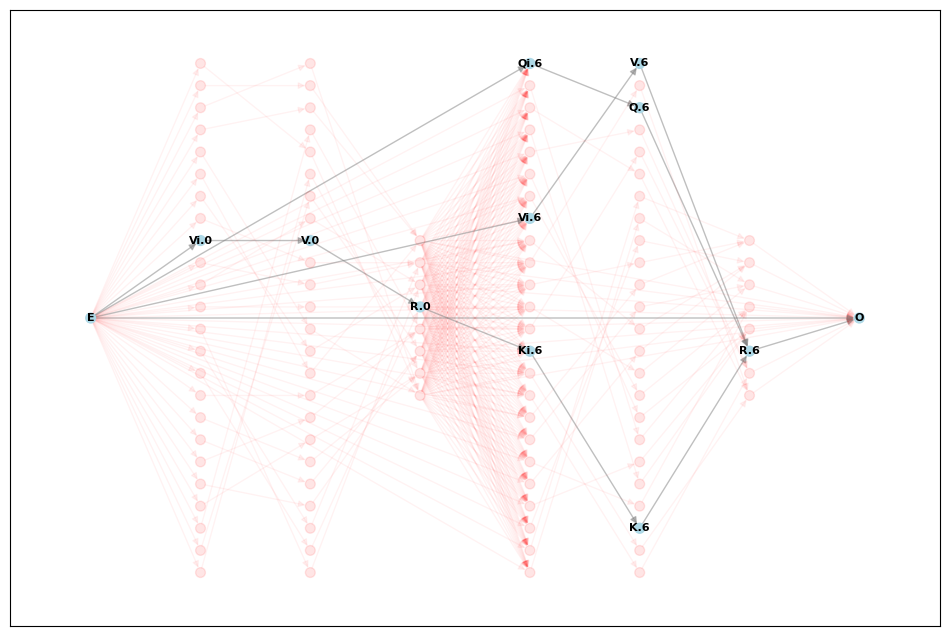

In [16]:
edges_present = [data['present'] for _, _, data in graph.edges(data=True)]
nodes_present = [
    len(out_edges := graph.out_edges(node, data=True)) == 0
    or any(data['present'] for _, _, data in out_edges)
    for node in graph.nodes]

plt.figure(figsize=(12, 8))
pos = nx.multipartite_layout(graph)
nx.draw_networkx_nodes(
    graph,
    pos,
    node_size=50,
    alpha=[1 if present else 0.1 for present in nodes_present],
    node_color=["lightblue" if present else "red" for present in nodes_present])
nx.draw_networkx_edges(
    graph,
    pos,
    node_size=50,
    alpha=[0.5 if present else 0.05 for present in edges_present],
    edge_color=["grey" if present else "red" for present in edges_present])
nx.draw_networkx_labels(
    graph,
    pos,
    labels={node: (label if present else "") for present, (node, label) in zip(nodes_present, labels.items())},
    font_size=8,
    font_weight=700,
    font_color="black")
plt.show()

# nx.draw_networkx_nodes(graph, pos, node_size=80, node_color="lightblue")
# nx.draw_networkx_edges(graph, pos, node_size=80, alpha=0.25, edge_color="grey")
# nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_weight=700, font_color='black')


In [ ]:
# for sender, receiver, data in graph.edges(data=True):
#     data["present"] = False

E = TransformerNode("hook_embed")
O = TransformerNode("blocks.1.hook_resid_post")
Qi0 = TransformerNode("blocks.0.hook_q_input", 0)
Ki0 = TransformerNode("blocks.0.hook_k_input", 0)
Q0 = TransformerNode("blocks.0.attn.hook_q", 0)
K0 = TransformerNode("blocks.0.attn.hook_k", 0)
R0 = TransformerNode("blocks.0.attn.hook_result", 0)
Qi6 = TransformerNode("blocks.1.hook_q_input", 6)
Vi6 = TransformerNode("blocks.1.hook_q_input", 6)


graph[E][Qi0]["present"] = True
graph[E][Ki0]["present"] = True
graph[Qi0][Q0]["present"] = True
graph[Ki0][K0]["present"] = True
graph[Q0][R0]["present"] = True
graph[K0][R0]["present"] = True
graph[R0][Qi6]["present"] = True
# graph[R0][Vi6]["present"] = False
graph[E][O]["present"] = False

In [17]:

logits, cache = model.run_with_cache(dataset)
(dataset[:, seq_len] == logits[:, -1, :].argmax(-1)).float().mean().item()

0.0